In [38]:
# Hücre 1: Temel Ayarlar ve Importlar
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, 
    roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
)
from src.utils.visualizations import (
    plot_confusion_matrix,
    plot_roc_curve,
    plot_precision_recall_curve,
    plot_feature_importance,
    plot_threshold_optimization,
    create_model_comparison_table
)

# Görselleştirme ayarları
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.dpi'] = 100
%matplotlib inline

# Proje sabitleri
MODELS_DIR = '../models'
DATA_DIR = '../data/processed'
REPORTS_DIR = '../reports'
os.makedirs(REPORTS_DIR, exist_ok=True)



def save_figure(fig, filename, show=True):
    """Görseli kaydeder ve istenirse ekranda gösterir"""
    fig_path = os.path.join(REPORTS_DIR, 'figures', filename)
    os.makedirs(os.path.dirname(fig_path), exist_ok=True)
    
    # Kaydet
    fig.savefig(fig_path, bbox_inches='tight', dpi=300)
    print(f"✔ Görsel kaydedildi: {fig_path}")
    
    # Göster (istenirse)
    if show:
        plt.show()
    else:
        plt.close()

In [39]:
def load_models_and_data():
    """Modelleri ve veriyi yüklerken tüm olası yolları dener"""
    import os
    from pathlib import Path
    
    # Olası kök dizinleri
    possible_roots = [
        Path.cwd(),                      # Mevcut çalışma dizini
        Path.cwd().parent,               # Bir üst dizin
        Path.home() / 'Desktop',         # Masaüstü
        Path.home() / 'Documents',       # Belgeler
        Path.home() / 'fraud_eye',       # Doğrudan ana klasör
        Path('C:/Users/PC/Desktop/fraud_eye')  # Mutlak yol
    ]
    
    # Dosya isimleri
    model_files = {
        'xgb': 'xgboost_model.pkl',
        'lr': 'logistic_regression_model.pkl',
        'test_data': 'processed_test.csv'
    }
    
    # Bulunan dosya yolları
    found_paths = {}
    
    # Tüm olası kombinasyonları dene
    for root in possible_roots:
        for file_type, filename in model_files.items():
            possible_path = root / 'models' / filename if file_type != 'test_data' else root / 'data' / 'processed' / filename
            
            if possible_path.exists() and file_type not in found_paths:
                found_paths[file_type] = possible_path
                print(f"✔ {file_type.upper()} bulundu: {possible_path}")
    
    # Eksik dosya kontrolü
    missing = [k for k in model_files if k not in found_paths]
    if missing:
        raise FileNotFoundError(f"❌ Eksik dosyalar: {', '.join(missing)}\n"
                              f"Lütfen dosyaların şu konumlarda olduğundan emin olun:\n"
                              f"- Modeller: /models/ klasöründe\n"
                              f"- Test verisi: /data/processed/ klasöründe")
    
    # Yükleme işlemleri
    try:
        xgb_model = joblib.load(found_paths['xgb'])
        lr_model = joblib.load(found_paths['lr'])
        test_df = pd.read_csv(found_paths['test_data'])
        
        print("\n✔ Tüm dosyalar başarıyla yüklendi!")
        print(f"XGBoost model tipi: {type(xgb_model)}")
        print(f"Logistic Regression model tipi: {type(lr_model)}")
        print(f"Test verisi boyutu: {test_df.shape}")
        
        return xgb_model, lr_model, test_df.drop(columns=['Class']), test_df['Class']
    
    except Exception as e:
        raise RuntimeError(f"Yükleme hatası: {str(e)}\n"
                         f"Yüklenen dosya yolları: {found_paths}")

# Çalıştır
try:
    xgb_model, lr_model, X_test, y_test = load_models_and_data()
except Exception as e:
    print(e)
    print("\n💡 İPUCU: Dosyaların doğru konumda olduğunu kontrol edin:")
    print("""
    fraud-detection/
    ├── models/
    │   ├── xgboost_model.pkl
    │   └── logistic_regression_model.pkl
    ├── data/
    │   └── processed/
    │       └── processed_test.csv
    """)

✔ XGB bulundu: C:\Users\PC\Desktop\fraud_eye\models\xgboost_model.pkl
✔ LR bulundu: C:\Users\PC\Desktop\fraud_eye\models\logistic_regression_model.pkl
✔ TEST_DATA bulundu: C:\Users\PC\Desktop\fraud_eye\data\processed\processed_test.csv

✔ Tüm dosyalar başarıyla yüklendi!
XGBoost model tipi: <class 'src.models.xgboost.XGBoostModel'>
Logistic Regression model tipi: <class 'src.models.logistic_regression.LogisticRegressionModel'>
Test verisi boyutu: (56962, 41)


2025-05-15 03:52:59,049 | INFO | xgboost.py:77 | Making probability predictions on 56962 samples


📊 XGBoost Performans Metrikleri
--------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.69      0.88      0.77        98

    accuracy                           1.00     56962
   macro avg       0.84      0.94      0.89     56962
weighted avg       1.00      1.00      1.00     56962

ROC AUC Score: 0.9828
Average Precision: 0.8737
✔ Görsel kaydedildi: ../reports\figures\xgboost_confusion.png


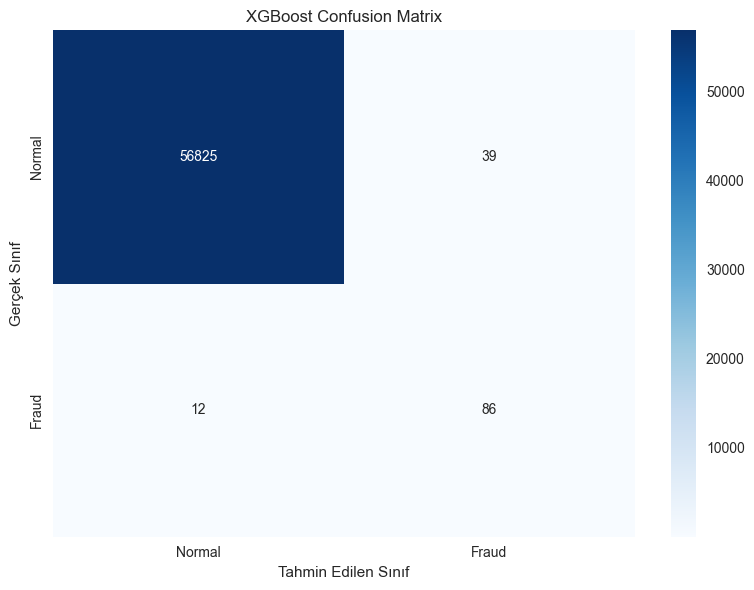

✔ Görsel kaydedildi: ../reports\figures\xgboost_roc.png


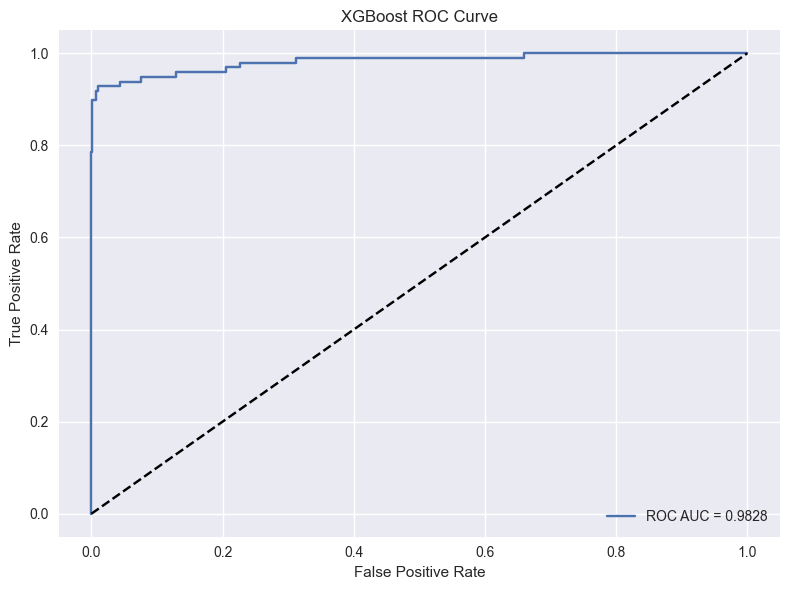

✔ Görsel kaydedildi: ../reports\figures\xgboost_pr.png


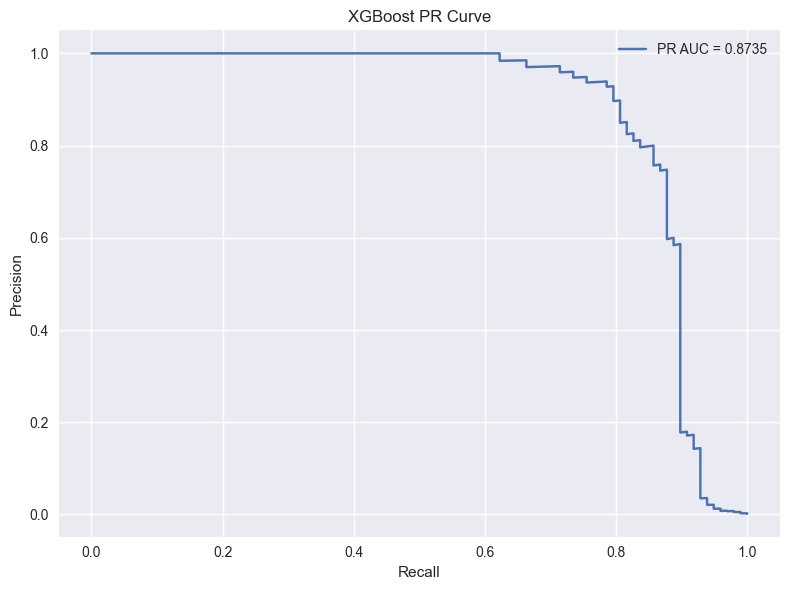

⚠ XGBoost modelinde feature_importances_ özelliği yok


In [40]:
# XGBoost için tahminler
xgb_probs = xgb_model.predict_proba(X_test)[:, 1]  # Probability estimates
xgb_preds = (xgb_probs >= 0.5).astype(int)  # Binary predictions

# Metrikler
print("📊 XGBoost Performans Metrikleri")
print("--------------------------------")
print(classification_report(y_test, xgb_preds))
print(f"ROC AUC Score: {roc_auc_score(y_test, xgb_probs):.4f}")
print(f"Average Precision: {average_precision_score(y_test, xgb_probs):.4f}")

# Görselleştirmeler
save_figure(
    plot_confusion_matrix(y_test, xgb_preds, title='XGBoost Confusion Matrix'),
    'xgboost_confusion.png'
)
save_figure(
    plot_roc_curve(y_test, xgb_probs, title='XGBoost ROC Curve')[0],
    'xgboost_roc.png'
)
save_figure(
    plot_precision_recall_curve(y_test, xgb_probs, title='XGBoost PR Curve')[0],
    'xgboost_pr.png'
)

# Feature Importance (sadece varsa)
if hasattr(xgb_model, 'feature_importances_'):
    importance_df = pd.DataFrame({
        'feature': X_test.columns,
        'importance': xgb_model.feature_importances_
    })
    save_figure(
        plot_feature_importance(importance_df, title='XGBoost Feature Importance'),
        'xgboost_importance.png'
    )
else:
    print("⚠ XGBoost modelinde feature_importances_ özelliği yok")

2025-05-15 03:53:00,345 | INFO | logistic_regression.py:55 | Making probability predictions on 56962 samples


📊 Logistic Regression Performans Metrikleri
------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.09      0.90      0.17        98

    accuracy                           0.98     56962
   macro avg       0.55      0.94      0.58     56962
weighted avg       1.00      0.98      0.99     56962

ROC AUC Score: 0.9710
Average Precision: 0.7249
✔ Görsel kaydedildi: ../reports\figures\logistic_confusion.png


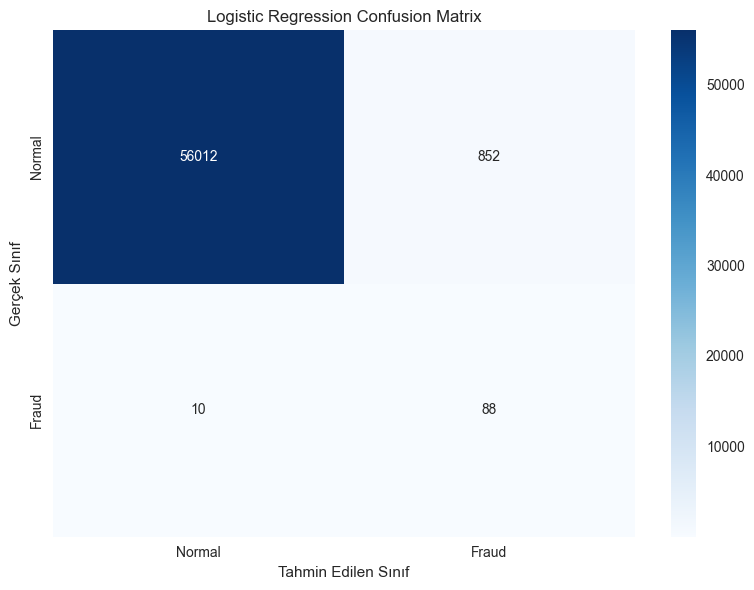

✔ Görsel kaydedildi: ../reports\figures\logistic_roc.png


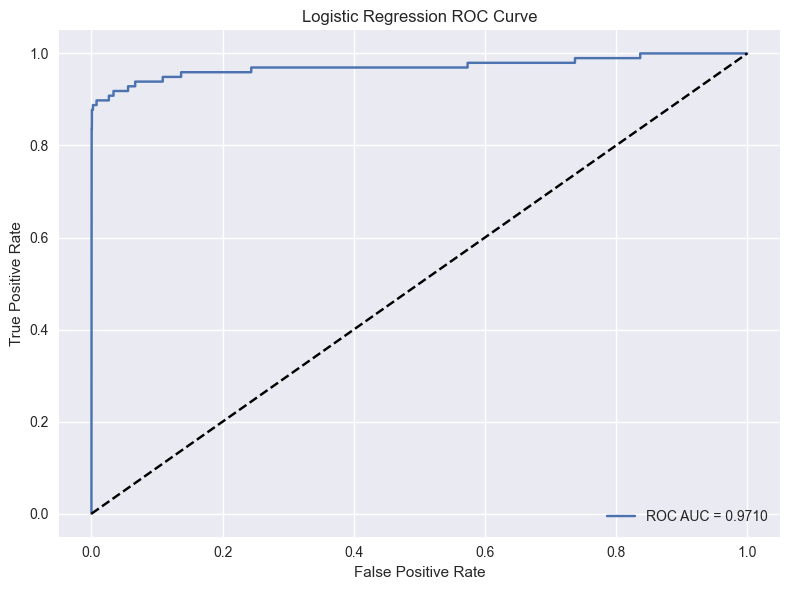

✔ Görsel kaydedildi: ../reports\figures\logistic_pr.png


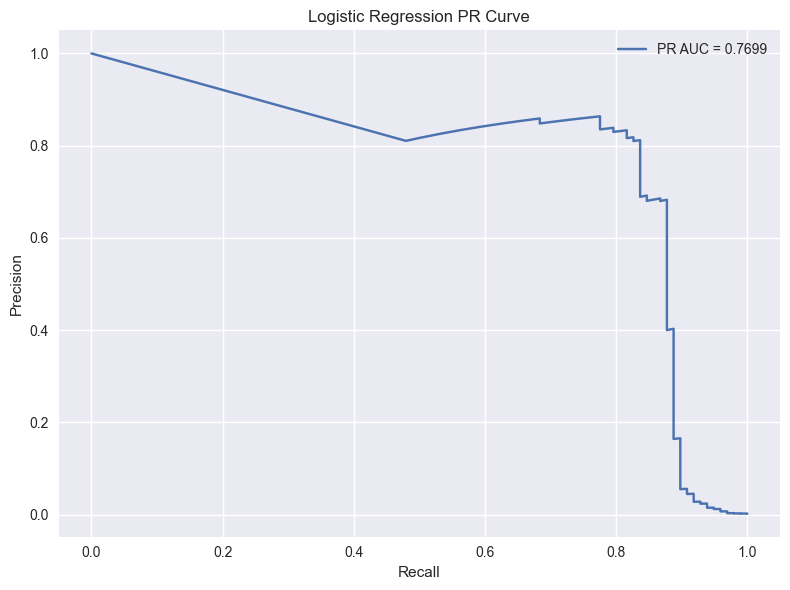

In [41]:
# Logistic Regression için tahminler
lr_probs = lr_model.predict_proba(X_test)[:, 1]
lr_preds = (lr_probs >= 0.5).astype(int)

# Metrikler
print("📊 Logistic Regression Performans Metrikleri")
print("------------------------------------------")
print(classification_report(y_test, lr_preds))
print(f"ROC AUC Score: {roc_auc_score(y_test, lr_probs):.4f}")
print(f"Average Precision: {average_precision_score(y_test, lr_probs):.4f}")

# Görselleştirmeler
save_figure(
    plot_confusion_matrix(y_test, lr_preds, title='Logistic Regression Confusion Matrix'),
    'logistic_confusion.png'
)
save_figure(
    plot_roc_curve(y_test, lr_probs, title='Logistic Regression ROC Curve')[0],
    'logistic_roc.png'
)
save_figure(
    plot_precision_recall_curve(y_test, lr_probs, title='Logistic Regression PR Curve')[0],
    'logistic_pr.png'
)

⭐ Model Karşılaştırması (CSV olarak kaydedildi)


,Accuracy,Precision,Recall,F1,ROC AUC,Avg Precision
XGBoost,0.999105,0.688000,0.877551,0.771300,0.982843,0.873696
Logistic Regression,0.984867,0.093617,0.897959,0.169557,0.970974,0.724916


✔ Görsel kaydedildi: ../reports\figures\model_comparison_roc.png


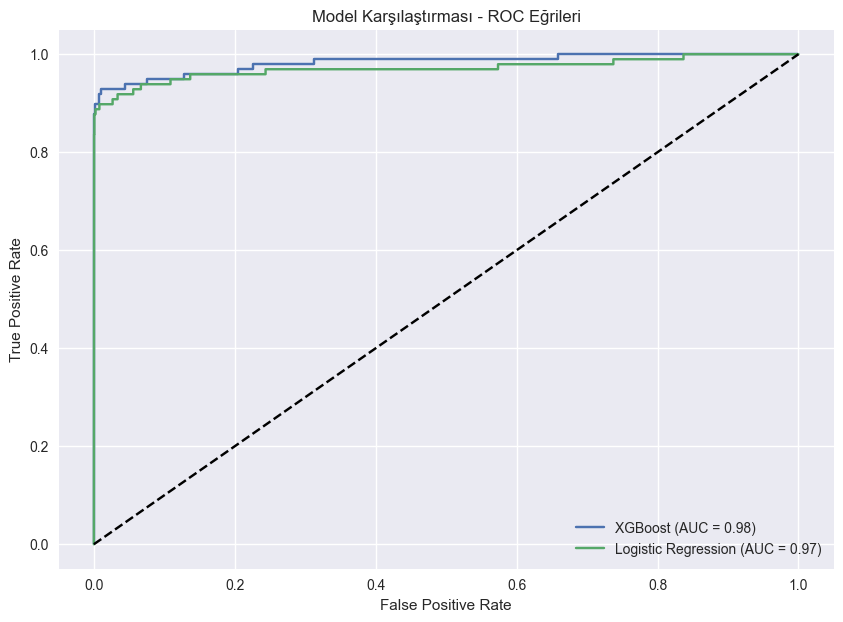

In [42]:
# Karşılaştırma Tablosu
metrics = {
    'XGBoost': {
        'Accuracy': accuracy_score(y_test, xgb_preds),
        'Precision': precision_score(y_test, xgb_preds),
        'Recall': recall_score(y_test, xgb_preds),
        'F1': f1_score(y_test, xgb_preds),
        'ROC AUC': roc_auc_score(y_test, xgb_probs),
        'Avg Precision': average_precision_score(y_test, xgb_probs)
    },
    'Logistic Regression': {
        'Accuracy': accuracy_score(y_test, lr_preds),
        'Precision': precision_score(y_test, lr_preds),
        'Recall': recall_score(y_test, lr_preds),
        'F1': f1_score(y_test, lr_preds),
        'ROC AUC': roc_auc_score(y_test, lr_probs),
        'Avg Precision': average_precision_score(y_test, lr_probs)
    }
}

# DataFrame'e çevir ve kaydet
metrics_df = pd.DataFrame(metrics).T
metrics_df.to_csv(os.path.join(REPORTS_DIR, 'model_metrics.csv'))
print("⭐ Model Karşılaştırması (CSV olarak kaydedildi)")
display(metrics_df.style.background_gradient(cmap='Blues'))

# ROC Eğrilerini Karşılaştır
plt.figure(figsize=(10, 7))
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_probs)
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_probs)

plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_score(y_test, xgb_probs):.2f})')
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_score(y_test, lr_probs):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model Karşılaştırması - ROC Eğrileri')
plt.legend()
save_figure(plt.gcf(), 'model_comparison_roc.png')
plt.show()